In [1]:
import pandas as pd
import time, os, shutil
import re
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np  
from sklearn.cluster import KMeans  
from sklearn.cluster import DBSCAN
from nltk.parse import CoreNLPParser
from sklearn import decomposition as dc

#pos_tagger = CoreNLPParser(url='http://localhost:9000', tagtype='pos')

W0602 22:44:32.278954  4868 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [2]:
#############################LOAD##################
# If load data with 'text' and 'main'
data_source = 'output/sub-set/'
file_name = 'AmazonBasics Wireless Mouse'+'.csv'
reviews = pd.read_csv(data_source+file_name, sep="\t", error_bad_lines=False).loc[:,['text']]
###################################################

In [3]:
import re

def remove_banned(s,words):
    #words = sorted(words, key=len, reverse=True)
    pattern = '|'.join(words)
    s = re.sub(pattern, '', s, flags = re.I) # remove words
    s = re.sub(r'[0-9]+', '', s) # remove numbers
    s = re.sub('\s+', ' ', s, flags = re.I) # remove extra blank space'
    return s

bannedWords = ['hi', 'hi you', 'hello', 'and you']
s = "Hi, Hello, hi you, How are Tim and you doing"

print(remove_banned(s,bannedWords))

, , you, How are Tim doing


In [4]:
word_list = pd.read_csv('sentiment/wordlist.csv')
word_list = word_list.dropna()
word_list['count'] = word_list['word'].apply(lambda x: len(x.split()))
wd2 = word_list

In [5]:
word_list = word_list.sort_values(by=['count'],ascending =False).reset_index(drop=True)
word_list['word'] = word_list['word'].apply(lambda x: x+' ')
wordlist = word_list.loc[word_list['count']<10, ['word']]
wordlist = wordlist['word'].tolist()

In [6]:
one_word = wd2[wd2['count']==1]['word'].tolist()
mylist = ['love','loves','loved','like','likes','liked','enjoy','enjoys','enjoyed',
            'hate','hates','hated','do','does','did','don','don\'t','want','wants','wanted','ve']
subject = ['AmazonBasics','Wireless','Mouse']
for i in range(len(subject)):
    subject[i] = subject[i].lower()
one_word.extend(mylist)
one_word.extend(subject)
one_word = set(one_word)

In [7]:
def clean_review(x):

    words = one_word

    resultwords  = [word for word in re.split("[.,; :-?!&]+",x) if word.lower() not in words]
    result = ' '.join(resultwords)
    return result

In [8]:
clean_review('AAA bb love ccc, ve ddd don ve enjoys')

'AAA bb ccc ddd'

In [9]:
import contractions
reviews['removed'] = reviews['text'].apply(lambda x: remove_banned(x,wordlist))
reviews['removed'] = reviews['removed'].apply(lambda x: clean_review(x))
reviews['removed'] = reviews['removed'].apply(lambda x: contractions.fix(x))

In [10]:
def clean_numbers(line):
    line = re.sub('[0-9%]+','',line)
    line = re.sub(' +', ' ',line)
    return line.strip()

In [11]:
reviews['removed'] = reviews['removed'].apply(lambda x: clean_numbers(x))

In [12]:
reviews['removed'].tolist()[60:90]

['Based on my experience I would say that under use you can to replbatteries e- months',
 'it is a and I have kept up with it for awhile',
 'I have gone tha hassle keeping batteries for it though',
 'Works and as expected',
 'Only under dollars but works a',
 'Amazon Basics never fail to perform',
 'for everyday use and I always one as a',
 'and price',
 'Plug in the Nano receiver',
 'Precision up down left and scrolling',
 'To zoom press the Ctrl while scroll to zoom in and out',
 'This item meets all my expectations',
 'I was thinking about cancelling my internet service because my tablet touch was not working',
 'The pointer kept on freezing',
 'Had to manually shutdown the tablet (pressing down on the power button)',
 'But this is',
 'take out of the box install the batteries then attach the card to the computer then turn on',
 'that is it my tablet is as',
 'I would of given it stars but the on/off switch is',
 'My granddad was having issues with the trackpad as he transitioned fr

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from itertools import islice


In [14]:
cvec = CountVectorizer(stop_words='english', min_df=0.001, max_df=.2, ngram_range=(2,3))
cvec.fit(reviews.removed)
len(cvec.vocabulary_)
#list(islice(cvec.vocabulary_.items(), 20))

112

In [15]:
cvec_counts = cvec.transform(reviews.removed)
print('sparse matrix shape:', cvec_counts.shape)
print('nonzero count:', cvec_counts.nnz)
print('sparsity: %.2f%%' % (100.0 * cvec_counts.nnz / (cvec_counts.shape[0] * cvec_counts.shape[1])))
occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': cvec.get_feature_names(), 'occurrences': occ})
#counts_df.sort_values(by='occurrences', ascending=False).head(20)

sparse matrix shape: (7149, 112)
nonzero count: 1940
sparsity: 0.24%


In [16]:
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(cvec_counts)
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df = weights_df.sort_values(by='weight', ascending=False).reset_index(drop=True)

In [17]:
key_words = weights_df[weights_df.weight>=0.0005]

In [18]:
len(key_words)

112

In [19]:
key_words

,term,weight
0,battery life,0.012866
1,nano receiver,0.012567
2,amazon basics,0.009690
3,scroll wheel,0.008360
4,usb receiver,0.007294
5,fits hand,0.007076
6,battery compartment,0.006376
7,usb port,0.005896
8,stopped working,0.005537
9,plug play,0.004690


In [20]:
import pandas as pd
import time, os, shutil
import re
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np  
from sklearn.cluster import KMeans  
from sklearn.cluster import DBSCAN
from nltk.parse import CoreNLPParser
from sklearn import decomposition as dc

In [21]:
# Load google Universal Sentence Encoder
module_dir ="downloads/encoder-DNA" #"downloads/encoder"
embed = hub.Module(module_dir)


Instructions for updating:
Colocations handled automatically by placer.


W0602 22:46:31.769768  4868 deprecation.py:323] From C:\Users\betty\Anaconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [22]:
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    start_time=time.time()
    key_words['embedding'] = pd.Series(list(session.run(embed(list(key_words['term'])))))
    end_time1=time.time()
    print('time1:',(end_time1-start_time))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0602 22:47:01.070968  4868 saver.py:1483] Saver not created because there are no variables in the graph to restore


time1: 3.9049010276794434


In [23]:
terms = key_words['term'].tolist()
embs = key_words['embedding'].tolist()

In [24]:
##
X = np.array(embs,)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X2 = pca.fit_transform(embs)

In [25]:
X.shape

(112, 512)

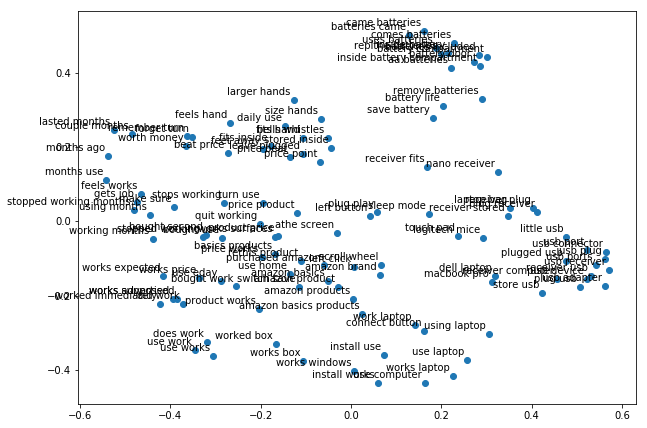

In [34]:
import matplotlib.pyplot as plt

labels = terms 
plt.figure(figsize=(10, 7))  
plt.subplots_adjust(bottom=0.1)  
plt.scatter(X2[:,0],X2[:,1], label='True Position')

for label, x, y in zip(labels, X2[:, 0], X2[:, 1]):  
    plt.annotate(
        label,
        xy=(x, y), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')
plt.show()  

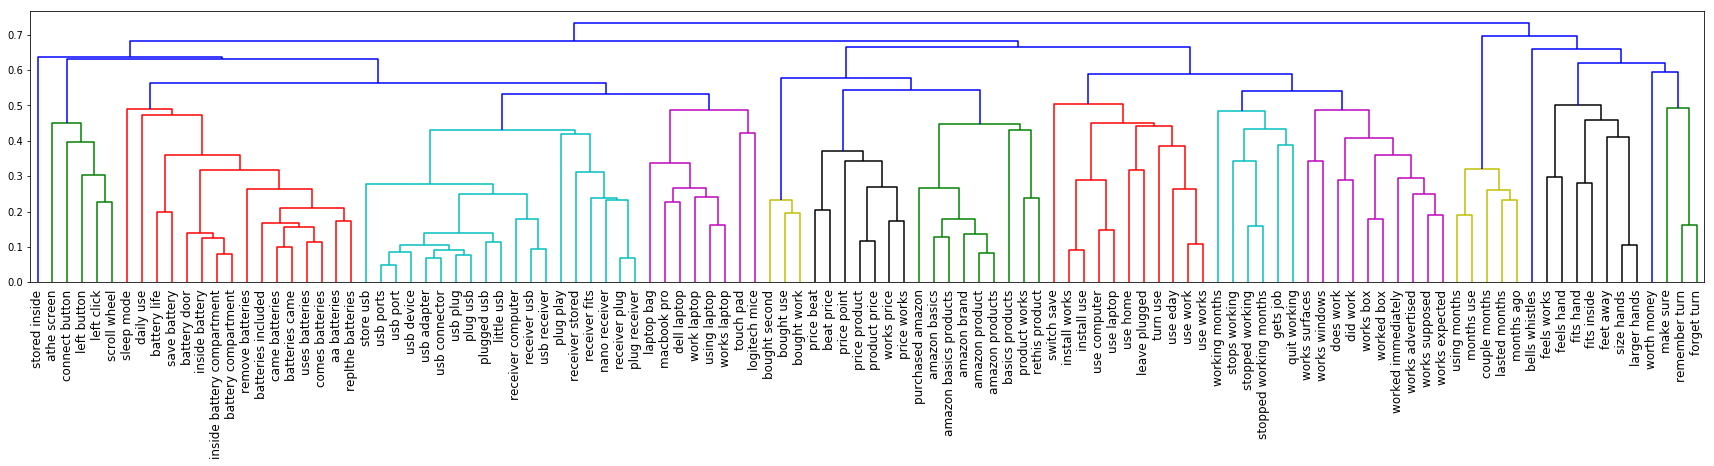

In [27]:
from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist

#dist_condensed = pdist(X)
#linked = linkage(X, 'single',metric='cosine',optimal_ordering=True)
linked = linkage(X, 'average', metric='cosine',optimal_ordering=True)
labelList = terms

plt.figure(figsize=(30, 5))  
dh = dendrogram(linked,  
            orientation='top',
            labels=labelList,
            leaf_font_size=12,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()  

In [28]:
import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The nltk version is 3.4.
The scikit-learn version is 0.21.2.


In [29]:
import matplotlib.pyplot as plt  
import pandas as pd  
%matplotlib inline
import numpy as np  
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=None, affinity='cosine', linkage='average', distance_threshold =0.45)  
term_clusters = cluster.fit_predict(X)  
term_clusters

array([ 8,  7,  1, 15,  7, 11,  8,  7,  3,  7, 17,  6,  0,  8,  6,  5,  8,
        6, 14,  3,  1,  2,  7,  2,  5,  0, 15,  1,  2,  6,  9,  9,  9,  8,
        7,  2,  9, 10,  8,  2,  0,  7,  1,  8,  5,  0, 21, 23,  6,  0,  5,
        7,  8,  6,  4,  2,  7,  9, 10, 18, 21, 15,  6,  7,  0,  4,  0,  8,
       19,  1, 14,  8, 24,  3,  7,  7, 12,  7, 15, 25, 10,  1,  1, 20,  2,
        8,  5,  7,  0,  9,  3,  2, 12, 17,  7,  0,  8,  7,  1,  1, 16, 22,
        8, 13,  8,  7,  0, 11, 12,  7,  3,  7], dtype=int64)

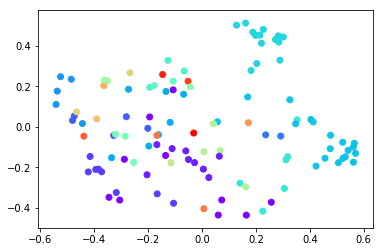

In [30]:
plt.scatter(X2[:,0],X2[:,1], c=cluster.labels_, cmap='rainbow') 

In [31]:
cluster_numbers = np.amax(term_clusters)
print('Number of keyword clusters:',cluster_numbers)

Number of keyword clusters: 25


In [32]:
cluster_data = {'term':terms, 'cluster':term_clusters}
df_cluster = pd.DataFrame(cluster_data)

In [35]:
df_cluster.to_csv("output/wireless_mouse_keywords.csv",index=False)
####### load
df_cluster = pd.read_csv("output/wireless_mouse_keywords.csv")
cluster_numbers = np.amax(df_cluster.cluster.tolist())

In [36]:
# Load google Universal Sentence Encoder
module_dir ="downloads/encoder-DNA" #"downloads/encoder"
embed = hub.Module(module_dir)

with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    start_time=time.time()
    df_cluster['embedding'] = pd.Series(list(session.run(embed(list(df_cluster['term'])))))
    end_time1=time.time()
    print('time1:',(end_time1-start_time))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0602 22:48:51.887254  4868 saver.py:1483] Saver not created because there are no variables in the graph to restore


time1: 4.97915506362915


In [37]:
df_cluster.head()

,term,cluster,embedding
0,battery life,8,"[0.008102105, -0.017975343, -0.046883713, 0.05..."
1,nano receiver,7,"[0.07769245, 0.031042438, -0.07468718, 0.04138..."
2,amazon basics,1,"[0.035013646, 0.020044124, -0.07199213, 0.0696..."
3,scroll wheel,15,"[-0.029888077, 0.046411037, -0.044371452, 0.06..."
4,usb receiver,7,"[0.0717718, -0.011592845, -0.05392894, 0.03932..."


In [38]:
group = []
emb_group = []
for i in range(cluster_numbers+1):
    terms_in_group = df_cluster.loc[df_cluster['cluster']==i]['term'].tolist()
    embs_in_group = df_cluster.loc[df_cluster['cluster']==i]['embedding'].tolist()
    if len(terms_in_group)>=3:
        group.append(terms_in_group)
        emb_group.append(embs_in_group)
        print('Group '+str(i)+':\n',terms_in_group,'\n')

Group 0:
 ['use laptop', 'use work', 'install works', 'install use', 'turn use', 'use computer', 'use home', 'use works', 'use eday', 'leave plugged'] 

Group 1:
 ['amazon basics', 'amazon product', 'amazon products', 'rethis product', 'amazon brand', 'amazon basics products', 'basics products', 'purchased amazon', 'product works'] 

Group 2:
 ['works expected', 'works advertised', 'does work', 'works box', 'worked box', 'works supposed', 'worked immediately', 'did work'] 

Group 3:
 ['stopped working', 'gets job', 'stops working', 'quit working', 'stopped working months'] 

Group 5:
 ['couple months', 'using months', 'lasted months', 'months use', 'months ago'] 

Group 6:
 ['product price', 'works price', 'beat price', 'price works', 'price point', 'price beat', 'price product'] 

Group 7:
 ['nano receiver', 'usb receiver', 'usb port', 'plug play', 'usb plug', 'usb ports', 'plugged usb', 'usb connector', 'receiver usb', 'receiver stored', 'little usb', 'store usb', 'usb adapter', 'plu

In [39]:
avg_embs = []

for embs in emb_group:
    temp_avg = np.zeros(len(embs[0]))
    for term_emb1 in embs:
        temp_avg = temp_avg+term_emb1
        term_avg = temp_avg/len(embs)
    avg_embs.append(term_avg)

In [40]:
data2 = {'terms':group, 'avg_emb':avg_embs}
cluster_embs = pd.DataFrame(data2)
cluster_embs

,terms,avg_emb
0,"[use laptop, use work, install works, install ...","[0.029204447427764534, 0.009492243826389312, 0..."
1,"[amazon basics, amazon product, amazon product...","[0.024645398577882185, 0.026265325671475794, -..."
2,"[works expected, works advertised, does work, ...","[-0.005431369063444436, 0.03316690900828689, -..."
3,"[stopped working, gets job, stops working, qui...","[-0.003327854070812464, 0.04604922458529472, -..."
4,"[couple months, using months, lasted months, m...","[-0.01002017706632614, 0.020697302743792535, -..."
5,"[product price, works price, beat price, price...","[0.030878032291574136, 0.03310241550207138, -0..."
6,"[nano receiver, usb receiver, usb port, plug p...","[0.06043896412378863, 0.008647179280064608, -0..."
7,"[battery life, battery compartment, comes batt...","[-0.0033347324767549124, 0.021343456697650254,..."
8,"[laptop bag, using laptop, works laptop, macbo...","[0.010853486911704143, 0.0488031132457157, -0...."
9,"[size hands, feet away, larger hands]","[-0.012619717861525714, 0.0011157691478729248,..."


In [41]:
import pickle
pickle.dump(cluster_embs, open("output/wireless_mouse_embs.pickle", "wb"))

In [42]:
test_load = pickle.load(open("output/wireless_mouse_embs.pickle", "rb"))
test_load

,terms,avg_emb
0,"[use laptop, use work, install works, install ...","[0.029204447427764534, 0.009492243826389312, 0..."
1,"[amazon basics, amazon product, amazon product...","[0.024645398577882185, 0.026265325671475794, -..."
2,"[works expected, works advertised, does work, ...","[-0.005431369063444436, 0.03316690900828689, -..."
3,"[stopped working, gets job, stops working, qui...","[-0.003327854070812464, 0.04604922458529472, -..."
4,"[couple months, using months, lasted months, m...","[-0.01002017706632614, 0.020697302743792535, -..."
5,"[product price, works price, beat price, price...","[0.030878032291574136, 0.03310241550207138, -0..."
6,"[nano receiver, usb receiver, usb port, plug p...","[0.06043896412378863, 0.008647179280064608, -0..."
7,"[battery life, battery compartment, comes batt...","[-0.0033347324767549124, 0.021343456697650254,..."
8,"[laptop bag, using laptop, works laptop, macbo...","[0.010853486911704143, 0.0488031132457157, -0...."
9,"[size hands, feet away, larger hands]","[-0.012619717861525714, 0.0011157691478729248,..."


In [43]:
cluster_centers = test_load['avg_emb'].tolist()
cluster_centers_labels = test_load['terms'].tolist()

In [44]:
#############################LOAD##################
# If load data with 'text' and 'main'
data_source = 'output/sub-set/'
file_name = 'AmazonBasics Wireless Mouse'+'.csv'
reviews = pd.read_csv(data_source+file_name, sep="\t", error_bad_lines=False).loc[:,['text']]
###################################################

In [45]:
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    start_time=time.time()
    reviews['embedding'] = pd.Series(list(session.run(embed(list(reviews['text'])))))
reviews.head()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0602 22:49:52.218391  4868 saver.py:1483] Saver not created because there are no variables in the graph to restore


,text,embedding
0,"This works great for my laptop, its nice and s...","[0.06468204, 0.05372226, -0.031698454, 0.03890..."
1,After 8 months it no longer works,"[-0.032307226, 0.018750511, -0.0404305, 0.0377..."
2,I would like another or a replacement,"[0.05728683, -0.023472648, -0.031718504, 0.028..."
3,Surprisingly pleased with this wireless mouse,"[0.06731313, 0.018472131, -0.034584843, 0.0642..."
4,Works great and have not had any complaints,"[0.041073218, 0.029133081, -0.012827984, -0.02..."


In [46]:
def find_closest(centers, text_emb):
    distances = np.inner(centers,text_emb)
    if np.amax(distances)<=0.5:
        return -1
    else:
        return np.where(distances == np.amax(distances))[0][0]

In [47]:
reviews['cluster'] = reviews['embedding'].apply(lambda x: find_closest(cluster_centers,x))
reviews

,text,embedding,cluster
0,"This works great for my laptop, its nice and s...","[0.06468204, 0.05372226, -0.031698454, 0.03890...",8
1,After 8 months it no longer works,"[-0.032307226, 0.018750511, -0.0404305, 0.0377...",4
2,I would like another or a replacement,"[0.05728683, -0.023472648, -0.031718504, 0.028...",-1
3,Surprisingly pleased with this wireless mouse,"[0.06731313, 0.018472131, -0.034584843, 0.0642...",8
4,Works great and have not had any complaints,"[0.041073218, 0.029133081, -0.012827984, -0.02...",2
5,I'm kind of clumsy so it has been dropped seve...,"[0.066287264, 0.032198057, -0.03290658, -0.037...",-1
6,The batteries that were included from Amazon h...,"[0.031579353, 0.05033474, -0.037744936, -0.005...",7
7,"Would buy again if needed, but its still worki...","[0.0696619, 0.0027663205, -0.021256551, 0.0046...",-1
8,"Nice, simple to use mouse","[0.051598992, -0.021314897, -0.048857514, 0.06...",11
9,"It feels perfect, it's extremely responsive, a...","[0.057611007, 0.071474336, -0.048765596, 0.016...",-1


In [48]:
len1 = len(cluster_centers)
clustered_sentences = []
for i in range(len1):
    s1 = reviews.loc[reviews['cluster']==i,['text']]['text'].tolist()
    print('cluster',i,'----  contents:',cluster_centers_labels[i],'\n')
    print(s1)
    print('\n\n')
    temp_str = ''
    for j in range(len(s1)):
        temp_str = temp_str + s1[j] + '. '
    clustered_sentences.append(temp_str)
pickle.dump(clustered_sentences, open("output/wireless_mouse_sentences.pickle", "wb"))

cluster 0 ----  contents: ['use laptop', 'use work', 'install works', 'install use', 'turn use', 'use computer', 'use home', 'use works', 'use eday', 'leave plugged'] 

['easy to use  works fine', 'Easy to install and use', 'Easy to use and works well', "If you use a KVM, don't try this one", 'Easy to install and use', 'Easy to install, works great', 'Very easily to use and set it', 'Other &#34;mice&#34; work fine …', 'Use this regularly and it works great', 'Simple to use and set up', 'Plug in and start mousing', 'Easy to install and works very well', 'Easy to install and use', 'Nothing in the settings helps']



cluster 1 ----  contents: ['amazon basics', 'amazon product', 'amazon products', 'rethis product', 'amazon brand', 'amazon basics products', 'basics products', 'purchased amazon', 'product works'] 

['Amazon Basics never fail to perform', 'Another great product from Amazon', 'Love Amazon basics because it works and is inexpensive', 'Once again, Amazon basics did it right', "T